In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# 경고 무시 모듈
import warnings
# 경고를 무시
warnings.filterwarnings(action='ignore')

D:\ANACONDA3\envs\py38-env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(


In [32]:
encoding= 'cp949'
file_name = 'agg_pcell_time_service_pop_2022_1'
User_point = pd.read_csv(f'./전처리/grid/{file_name}.csv', encoding=encoding)

In [33]:
User_point

gid  recordid                                           geom  \
0      30728485  37655633   POINT (1123733.991787065 1711829.1473899658)   
1      30766272  37689642  POINT (1123233.9917870644 1711529.1473899654)   
2      30766273  37689643  POINT (1123283.9917870667 1711529.1473899658)   
3      30766276  37689646   POINT (1123433.991787067 1711529.1473899654)   
4      30772589  37695327    POINT (1123233.991787064 1711479.147389966)   
...         ...       ...                                            ...   
74492  34327160  40894440   POINT (1125383.991787071 1684879.1473899633)   
74493  34333930  40900532  POINT (1124933.9917870678 1684829.1473899635)   
74494  34333931  40900533    POINT (1124983.991787067 1684829.147389964)   
74495  34333932  40900534   POINT (1125033.991787069 1684829.1473899637)   
74496  34333933  40900535   POINT (1125083.991787069 1684829.1473899642)   

              hcode    year  month  h_pop  w_pop  v_pop  sum_pop  
0      4.825035e+09  2022.0    1.0    7.0    2.0    0.0     10.0  
1      4.825035e+09  2022.0    1.0    0.0    0.0    0.0      0.0  
2      4.825035e+09  2022.0    1.0    0.0    0.0    0.0      0.0  
3      4.825035e+09  2022.0    1.0    0.0    0.0    0.0      0.0  
4      4.825035e+09  2022.0    1.0    0.0    0.0    0.0      0.0  
...             ...     ...    ...    ...    ...    ...      ...  
74492  4.825063e+09  2022.0    1.0  896.0   35.0   91.0   1022.0  
74493  4.825063e+09  2022.0    1.0   17.0    0.0    0.0     17.0  
74494  4.825063e+09  2022.0    1.0   14.0    0.0    0.0     14.0  
74495  4.825063e+09  2022.0    1.0   14.0    0.0    0.0     14.0  
74496  4.825063e+09  2022.0    1.0   14.0    0.0    0.0     14.0  

[74497 rows x 10 columns]

In [31]:
encoding= 'cp949'
file_name = 'agg_pcell_time_service_pop_2022_1~12'



epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
epsg5179 = from_string("+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs")




# 도시재생화사업지
city_recycle = gpd.GeoDataFrame.from_file('./원본데이터/도시재생사업지_epsg4326/도시재생사업지.shp', 
                                          encoding=encoding, crs=epsg4326)
city_recycle =  city_recycle.to_crs(epsg5179)




# 그리드와 병합할 포인트
User_point = pd.read_csv(f'./전처리/grid/{file_name}.csv', encoding=encoding)

User_point['x'] = None
User_point['y'] = None

for n in tqdm(range(len(User_point))):
    xy = User_point['geom'][n].split()
    User_point['x'][n] = float(xy[1].split('(')[1])
    User_point['y'][n] = float(xy[2].split(')')[0])

User_point.drop('geom', axis=1, inplace=True)
User_point['geometry'] = User_point.apply(lambda row : Point([row['x'], row['y']]), axis=1)

User_point = gpd.GeoDataFrame(User_point, geometry='geometry', crs = epsg5179)


# 공간 병합
result = gpd.sjoin(city_recycle, User_point, how='left', op="intersects")

result = result.groupby(['year_left','h_hong','name', 'type','year_right'])['h_pop','w_pop','v_pop','sum_pop'].sum()
result.reset_index(inplace=True)

In [30]:
result

year_left              h_hong                      name    type  \
0       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
1       2017                장유1동                포용과 화합의 무게  중심시가지형   
2       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
3       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
4       2021                 불암동              엄마야 누나야 강변살자  주거지지원형   

   year_right       pop  Month_mean  
0        2022  47451141     3954262  
1        2022   6324541      527045  
2        2022   4504070      375339  
3        2022   2827150      235596  
4        2022   3242224      270185

In [15]:
result.to_excel('./전처리/도시재생사업지/도시재생사업지_월평균.xlsx')

In [33]:
result.sort_values('h_hong', inplace=True)
result.reset_index(drop=True, inplace=True)
city_recycle.sort_values('h_hong', inplace=True)
city_recycle.reset_index(drop=True, inplace=True)

In [37]:
city_recycle_geo = city_recycle[['geometry']]

In [39]:
df = pd.concat([result, city_recycle_geo], axis=1)
df

year_left              h_hong                      name    type  \
0       2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
1       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
2       2017                장유1동                포용과 화합의 무게  중심시가지형   
3       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
4       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   

   year_right  month     h_pop    w_pop    v_pop   sum_pop  \
0        2022      3   1100724   199097   268189   1568068   
1        2022      3   2630271   276161   341404   3247942   
2        2022      3   2776019   221781   443592   3441460   
3        2022      3   1724302   174732   196002   2095145   
4        2022      3  11281174  1942420  3668516  16892990   

                                            geometry  
0  POLYGON ((1129611.310 1692709.840, 1129708.697...  
1  POLYGON ((1127995.022 1695301.445, 1127913.062...  
2  POLYGON ((1119809.445 1690458.296, 1119832.588...  
3  POLYGON ((1112395.413 1701364.809, 1112384.600...  
4  POLYGON ((1124909.721 1694616.391, 1126254.985...

In [34]:
def city_recycle(file_name, encoding='cp949'):
    epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    epsg5179 = from_string("+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs")

    # 도시재생화사업지
    city_recycle = gpd.GeoDataFrame.from_file('./원본데이터/도시재생사업지_epsg4326/도시재생사업지.shp', 
                                              encoding=encoding, crs=epsg4326)
    city_recycle =  city_recycle.to_crs(epsg5179)
    
    # 그리드와 병합할 포인트
    User_point = pd.read_csv(f'./전처리/grid/{file_name}.csv', encoding=encoding)

    User_point['x'] = None
    User_point['y'] = None

    for n in tqdm(range(len(User_point))):
        xy = User_point['geom'][n].split()
        User_point['x'][n] = float(xy[1].split('(')[1])
        User_point['y'][n] = float(xy[2].split(')')[0])

    User_point.drop('geom', axis=1, inplace=True)
    User_point['geometry'] = User_point.apply(lambda row : Point([row['x'], row['y']]), axis=1)

    User_point = gpd.GeoDataFrame(User_point, geometry='geometry', crs = epsg5179)

    # 공간 병합
    result = gpd.sjoin(city_recycle, User_point, how='left', op="intersects")
    
    result = result.groupby(['year_left','h_hong','name', 'type','year_right', 'month'])['h_pop','w_pop','v_pop','sum_pop'].sum()
    result.reset_index(inplace=True)
    
    result = result.astype({'year_right':int, 'month':int,
               'h_pop': int, 'w_pop': int,
               'v_pop':int, 'sum_pop':int})
    
    result.sort_values('h_hong', inplace=True)
    result.reset_index(drop=True, inplace=True)
    city_recycle.sort_values('h_hong', inplace=True)
    city_recycle.reset_index(drop=True, inplace=True)
    city_recycle_geo = city_recycle[['geometry']]
    
    df = pd.concat([result, city_recycle_geo], axis=1)
    
    month = df['month'][0]
    
    # GeoPandas로 변경
    df = gpd.GeoDataFrame(df, geometry='geometry', crs = epsg5179)
    
    # 폴더 생성
    try:
        directory = f'./전처리/도시재생사업지/shp/{month}/'
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
    
    # shp파일 저장
    df.to_file(f'{directory}{file_name}.shp', encoding='cp949', driver='ESRI Shapefile')
    
    # csv파일 저장
    df.to_csv(f'./전처리/도시재생사업지/csv/{file_name}.csv', encoding='cp949')

In [35]:
for n in tqdm(range(1,13)):
    city_recycle(f'agg_pcell_time_service_pop_2022_{n}')

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/74497 [00:00<?, ?it/s]

  0%|          | 0/74800 [00:00<?, ?it/s]

  0%|          | 0/74465 [00:00<?, ?it/s]

  0%|          | 0/75963 [00:00<?, ?it/s]

  0%|          | 0/76158 [00:00<?, ?it/s]

  0%|          | 0/75755 [00:00<?, ?it/s]

  0%|          | 0/76922 [00:00<?, ?it/s]

  0%|          | 0/77208 [00:00<?, ?it/s]

  0%|          | 0/77181 [00:00<?, ?it/s]

  0%|          | 0/77381 [00:00<?, ?it/s]

  0%|          | 0/77537 [00:00<?, ?it/s]

  0%|          | 0/75485 [00:00<?, ?it/s]

In [36]:
for n in range(1,13):
    df = pd.read_csv(f'./전처리/도시재생사업지/csv/agg_pcell_time_service_pop_2022_{n}.csv', encoding='cp949')
    
    if n == 1:
        cc_df = df
        continue
    cc_df = pd.concat([cc_df, df])

In [37]:
cc_df.drop(['Unnamed: 0','geometry'],axis=1,inplace=True)

In [38]:
cc_df.sort_values(['h_hong','month'],inplace=True)

In [39]:
cc_df.reset_index(drop=True, inplace=True)

In [42]:
cc_df.columns

Index(['year_left', 'h_hong', 'name', 'type', 'year_right', 'month', 'h_pop',
       'w_pop', 'v_pop', 'sum_pop'],
      dtype='object')

In [44]:
cc_df.set_index(['year_left', 'h_hong', 'name', 'type', 'year_right'], inplace=True)

In [46]:
cc_df.to_excel('./전처리/도시재생사업지/agg_pcell_time_service_pop_2022.xlsx')

# 꺾은선 그래프

In [2]:
import platform
from matplotlib import font_manager, rc # Runtime Configuration

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

In [9]:
df = pd.read_excel('./전처리/도시재생사업지/도시재생사업지/도시재생사업지_월별_df.xlsx')

In [10]:
df

year_left              h_hong                      name    type  \
0        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
1        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
2        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
3        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
4        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
5        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
6        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
7        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
8        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
9        2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
10       2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
11       2021                 불암동              엄마야 누나야 강변살자  주거지지원형   
12       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
13       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
14       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
15       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
16       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
17       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
18       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
19       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
20       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
21       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
22       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
23       2018                 삼안동  3-방이 소통하고 상생하는 어울림 캠퍼스타운  중심시가지형   
24       2017                장유1동                포용과 화합의 무게  중심시가지형   
25       2017                장유1동                포용과 화합의 무게  중심시가지형   
26       2017                장유1동                포용과 화합의 무게  중심시가지형   
27       2017                장유1동                포용과 화합의 무게  중심시가지형   
28       2017                장유1동                포용과 화합의 무게  중심시가지형   
29       2017                장유1동                포용과 화합의 무게  중심시가지형   
30       2017                장유1동                포용과 화합의 무게  중심시가지형   
31       2017                장유1동                포용과 화합의 무게  중심시가지형   
32       2017                장유1동                포용과 화합의 무게  중심시가지형   
33       2017                장유1동                포용과 화합의 무게  중심시가지형   
34       2017                장유1동                포용과 화합의 무게  중심시가지형   
35       2017                장유1동                포용과 화합의 무게  중심시가지형   
36       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
37       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
38       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
39       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
40       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
41       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
42       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
43       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
44       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
45       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
46       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
47       2019                 진영읍        사람과 공간을 이어주는 빛의 진영  중심시가지형   
48       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
49       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
50       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
51       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
52       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
53       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
54       2016  회현동, 북부동, 동상동, 부원동        2020 김해시 도시재생활성화계획  중심시가지형   
55       2016  회현동, 북부동, 동상동

In [13]:
pdf1 = pd.pivot_table(df,                
                     index = 'month',    # 행 위치에 들어갈 열
                     columns = 'name',    # 열 위치에 들어갈 열
                     values = ['pop']     # 데이터로 사용할 열
                     )
pdf1

pop                                              \
name  2020 김해시 도시재생활성화계획 3-방이 소통하고 상생하는 어울림 캠퍼스타운 사람과 공간을 이어주는 빛의 진영   
month                                                                  
1                3935855                   444438             245067   
2                3467263                   401222             213939   
3                3668516                   341404             196002   
4                3771168                   426912             209600   
5                4155400                   386679             233536   
6                3885919                   344217             216359   
7                4100271                   337451             241099   
8                4095941                   345148             249485   
9                3954268                   381274             253189   
10               4245295                   375320             260549   
11               3947258                   357091             244734   
12               4219260                   362401             263034   

                               
name  엄마야 누나야 강변살자 포용과 화합의 무게  
month                          
1           264905     583816  
2           247234     492930  
3           268189     443592  
4           258323     462522  
5           283762     508216  
6           257646     488414  
7           292175     594473  
8           273060     597447  
9           273755     598537  
10          272589     507333  
11          259150     470068  
12          291182     576761

In [14]:
pdf1.columns

MultiIndex([('pop',       '2020 김해시 도시재생활성화계획'),
            ('pop', '3-방이 소통하고 상생하는 어울림 캠퍼스타운'),
            ('pop',       '사람과 공간을 이어주는 빛의 진영'),
            ('pop',             '엄마야 누나야 강변살자'),
            ('pop',               '포용과 화합의 무게')],
           names=[None, 'name'])

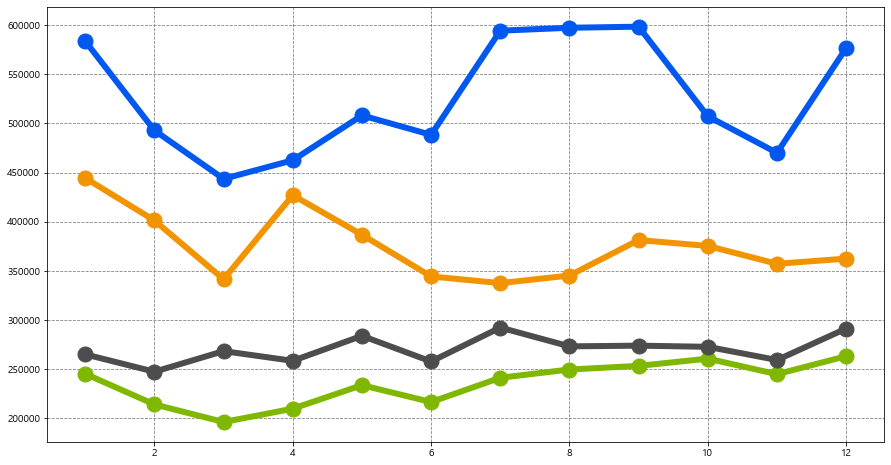

In [15]:
f, ax = plt.subplots(figsize=(15, 8), facecolor='w')
plt.rc('font', size=20)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')


x = pdf1.index

y_1 = pdf1[('pop', '2020 김해시 도시재생활성화계획')]
y_2 = pdf1[('pop', '3-방이 소통하고 상생하는 어울림 캠퍼스타운')]
y_3 = pdf1[('pop', '사람과 공간을 이어주는 빛의 진영')]
y_4 = pdf1[('pop', '엄마야 누나야 강변살자')]
y_5 = pdf1[('pop', '포용과 화합의 무게')]



# plt.plot(x, y_1,
#         linewidth='6',
#         color='r',
#         marker='o',
#         markersize=15)
plt.plot(x, y_2,
        linewidth='6',
        color='#f19400',
        marker='o',
        markersize=15)
plt.plot(x, y_3,
        linewidth='6',
        color='#80b700',
        marker='o',
        markersize=15)
plt.plot(x, y_4,
        linewidth='6',
        color='#4d4d4d',
        marker='o',
        markersize=15)
plt.plot(x, y_5,
        linewidth='6',
        color='#0058ef',
        marker='o',
        markersize=15)



# plt.xlabel('연도', labelpad=20, size=20, weight ='bold')
# plt.ylabel('의사수(명)', labelpad=20, size=20, weight ='bold')

#plt.ylim(0,11000)
#plt.legend(['의사(계)', '총 의료인력'], loc = (0.73, 0.5))

plt.show()

In [16]:
pdf1

pop                                              \
name  2020 김해시 도시재생활성화계획 3-방이 소통하고 상생하는 어울림 캠퍼스타운 사람과 공간을 이어주는 빛의 진영   
month                                                                  
1                3935855                   444438             245067   
2                3467263                   401222             213939   
3                3668516                   341404             196002   
4                3771168                   426912             209600   
5                4155400                   386679             233536   
6                3885919                   344217             216359   
7                4100271                   337451             241099   
8                4095941                   345148             249485   
9                3954268                   381274             253189   
10               4245295                   375320             260549   
11               3947258                   357091             244734   
12               4219260                   362401             263034   

                               
name  엄마야 누나야 강변살자 포용과 화합의 무게  
month                          
1           264905     583816  
2           247234     492930  
3           268189     443592  
4           258323     462522  
5           283762     508216  
6           257646     488414  
7           292175     594473  
8           273060     597447  
9           273755     598537  
10          272589     507333  
11          259150     470068  
12          291182     576761

In [18]:
y_1 = pdf1[('pop', '2020 김해시 도시재생활성화계획')]
y_2 = pdf1[('pop', '3-방이 소통하고 상생하는 어울림 캠퍼스타운')]
y_3 = pdf1[('pop', '사람과 공간을 이어주는 빛의 진영')]
y_4 = pdf1[('pop', '엄마야 누나야 강변살자')]
y_5 = pdf1[('pop', '포용과 화합의 무게')]

In [19]:
print('최대 :', y_1.max(), ',  최소 :', y_1.min())
print('최대 :', y_2.max(), ' ,  최소 :', y_2.min())
print('최대 :', y_3.max(), ' ,  최소 :', y_3.min())
print('최대 :', y_4.max(), ' ,  최소 :', y_4.min())
print('최대 :', y_5.max(), ' ,  최소 :', y_5.min())

최대 : 4245295 ,  최소 : 3467263
최대 : 444438  ,  최소 : 337451
최대 : 263034  ,  최소 : 196002
최대 : 292175  ,  최소 : 247234
최대 : 598537  ,  최소 : 443592


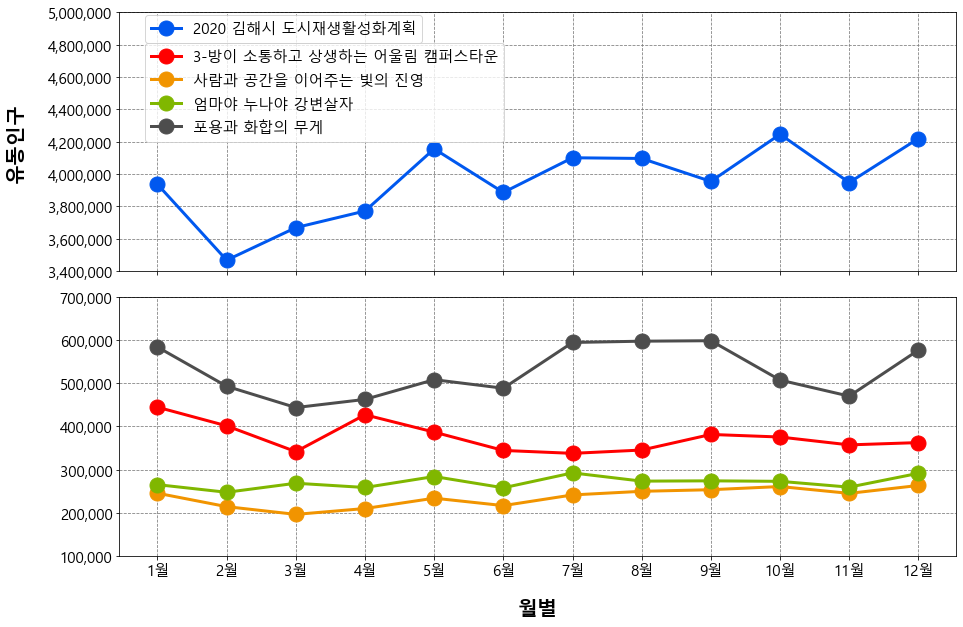

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10), facecolor='w')
fig.subplots_adjust(hspace = 0.07)
bar_width = 0.2

plt.rc('font', size=15)

x = []
for n in pdf1.index:
    x.append(f'{n}월')

y_1 = pdf1[('pop', '2020 김해시 도시재생활성화계획')]
y_2 = pdf1[('pop', '3-방이 소통하고 상생하는 어울림 캠퍼스타운')]
y_3 = pdf1[('pop', '사람과 공간을 이어주는 빛의 진영')]
y_4 = pdf1[('pop', '엄마야 누나야 강변살자')]
y_5 = pdf1[('pop', '포용과 화합의 무게')]


ax2.plot(x, y_2, linewidth='3',
        color='r',marker='o',markersize=15)
ax2.plot(x, y_3, linewidth='3',
        color='#f19400',marker='o',markersize=15)
ax2.plot(x, y_4, linewidth='3',
        color='#80b700',marker='o',markersize=15)
ax2.plot(x, y_5, linewidth='3',
        color='#4d4d4d',marker='o',markersize=15)

ax1.plot(x, y_1, linewidth='3',
        color='#0058ef',marker='o',markersize=15)

        
ax1.set_ylim(3400000, 5000000)
ax2.set_ylim(100000, 700000)

ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')

ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')

plt.xlabel('월별', labelpad=20, size=20, weight ='bold')
ax1.set_ylabel('유동인구', fontsize=20,labelpad=20, weight ='bold')

plt.subplots_adjust(wspace=0, hspace=0.1)


current_values_1 = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in current_values_1])

current_values_2 = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in current_values_2])


ax1.legend(['2020 김해시 도시재생활성화계획'], loc = (0.03, 0.88))
ax2.legend(['3-방이 소통하고 상생하는 어울림 캠퍼스타운','사람과 공간을 이어주는 빛의 진영',
            '엄마야 누나야 강변살자', '포용과 화합의 무게'], loc = (0.03, 1.60))

plt.show()